# A deep state-space model for a consumer credit risk portfolio

This notebook describes the creation of a deep state-space model for consumer credit risk using [pyro.ai](https://pyro.ai/). At the heart of the model lies a monte-carlo simulation for each loan, simulating monthly timesteps where the hidden state represents the loan status at each point in time. All accounts start as up to date, from where they may become paid off early, fall ionto arrears, or most likely simply move to the next month as up to date.

The model requires just 2 parameters as input: the anticipated cashflows i.e. the installment schedule for the loan, and a simple embedding based on the loan account identifier that is trained alongside the other model parameters. The output against which the model is trained is simply the corresponding realised cashflows i.e. the sequence of payments that were made. The account identifier based embedding can either be used as-is for simulating the existing portfolio, perhaps extending the installment sequence to maturity in order to evaluate the value of the book if it were to be allowed to run off, or used as a low dimentional representation of loan performnace to extend well beyond the traditional definition of good/bad accounts against which to train applicant level models.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn.functional as F

from typing import List, Tuple
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [12]:
import seaborn as sns
import matplotlib.pylab as plt

First we read in the file containing the timerseries of installment and pymnt values we inferred earlier from the Lending Club dataset.

In [3]:
df_parquet = pd.read_parquet('../../lendingclub/accepted_2007_to_2018Q4.parquet.gz')

In [4]:
scaling_factor = 1_000
df_parquet = df_parquet / scaling_factor # scale to make the gradients more manageable ($500 becomes 0.0005 etc.)

Here we aggregate all the installments and payments into a pair of tensors for each loan. We also calulate the length by which to sort the sequences later, and add a flag where all `pymnt` entries were missing as these cannot be processed. 

In [5]:
df_train = df_parquet.groupby(level=0).apply(lambda x: pd.Series({
    'length': len(x.installment),
    'installment': torch.tensor(x.installment.tolist(), dtype=torch.float),
    'pymnt': torch.tensor(x.pymnt.fillna(0).tolist(), dtype=torch.float),
    'cancelled': x.pymnt.isna().all()
}), include_groups=False)

In [6]:
df_train

,length,installment,pymnt,cancelled
id,,,,
1000007,60,"[tensor(0.1326), tensor(0.1326), tensor(0.1326...","[tensor(0.1326), tensor(0.1326), tensor(0.1326...",False
100001133,24,"[tensor(0.9434), tensor(0.9434), tensor(0.9434...","[tensor(0.7961), tensor(0.7961), tensor(0.7961...",False
100001137,24,"[tensor(0.3005), tensor(0.3005), tensor(0.3005...","[tensor(0.3005), tensor(0.3005), tensor(0.3005...",False
100001142,24,"[tensor(0.5932), tensor(0.5932), tensor(0.5932...","[tensor(0.5932), tensor(0.5932), tensor(0.5932...",False
100001158,24,"[tensor(0.2308), tensor(0.2308), tensor(0.2308...","[tensor(0.2308), tensor(0.2308), tensor(0.2308...",False
...,...,...,...,...
99997746,23,"[tensor(0.1567), tensor(0.1567), tensor(0.1567...","[tensor(0.1567), tensor(0.1567), tensor(0.1567...",False
99997759,24,"[tensor(0.7897), tensor(0.7897), tensor(0.7897...","[tensor(0.7897), tensor(0.7897), tensor(0.7897...",False
999981,36,"[tensor(0.1677), tensor(0.1677), tensor(0.1677...","[tensor(0.1677), tensor(0.1677), tensor(0.1677...",False


The model has been designed such that it can train / simulate a large number of accounts in parallel on a GPU. If you don't have a suitable GPU installed on your machine simply replace `cuda:0` here with `cpu`. To achieve this we need to consider how the data is to be fed into the model. One of consideration with batching the tasks is that it is preferable to present the longest sequences first as these contain the most information, but more importanly than that, that all sequences in a batch ultimately have the same length. We pad the sequences out with 0, which is perfectly applicable to both the expected and realised payment seqences.

We take a subset of the 2+ million accounts available here for speed.

In [9]:
device = 'cuda:0'

In [8]:
class DataFrameDataset(Dataset):
    '''
    Wrap the dataframe in a custom Dataset to feed the DataLoader.
    '''
    
    def __init__(self, dataframe):

        # drop the original index here to ensure it is suitable to double as the embeddings index later
        self.data = dataframe.reset_index(drop=True)

    def __len__(self):

        # return the length of the dataset
        return len(self.data)

    def __getitem__(self, idx):

        # return a row of the dataset given by idx
        row = self.data.iloc[idx]
        return idx, row.length, row.installment, row.pymnt

def collate_fn(data: List[Tuple[int, int, torch.Tensor, torch.Tensor]]):
    '''
    Define custom collate function to ensure all sequences within a DataLoader batch are the same length.
    '''

    # fist sort the keys by the second element of the dataset (length) to ensure longest sequence is processed first
    data.sort(key=lambda x: x[1], reverse=True)

    # unpack the elements of the dataset and make the index a tensor
    idx, length, installment, pymnt = zip(*data)
    idx = torch.tensor(idx)

    # pad installment and pymnt vectors to length of the first
    installment = pad_sequence(installment, batch_first=True, padding_value=0.)
    pymnt = pad_sequence(pymnt, batch_first=True, padding_value=0.)

    # return homogenised batch
    return idx, length, installment, pymnt

dataset = DataFrameDataset(df_train[df_train.cancelled==False].sample(384 * 16))

The pyro model is defined below. The state transition matrices define the probabilities at each time step, of moving from one loan status to another. The states are numbered 0-7 and represent the account being: paid early, up to date, 1 month late, 2 months late etc. up to 6 months late at which point the loan is assumed to have been charged off.

The first thing the forward step does is a lookup of the embedding based on the account identifier. The embedding is a low dimensional representation of the transition matrix that is parameterised below for each loan in the portfolio. This identifier is then: linearly transformed into 64 dimensional space, passed through an activation function to introduce some non-linearity, another linear function, reshaped into a 8x8 matrix, and finally passed thorugh softmax to ensure probabilities on any given row (i.e. for any given current/previous state) sum to 1.

In [5]:
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim

In [34]:
# Define the model
class BayesianNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, embedding_size):
        super().__init__()

        # define the embedding and linear terms to translate embedding to transition matrix
        self.embeddings = torch.nn.Embedding(input_size, embedding_size)
        self.linear1 = torch.nn.Linear(embedding_size, 64)
        self.linear2 = torch.nn.Linear(64, 64)

        # define a hand-crafted matrix for demonstration purposes only
        self.tmat_demo = torch.tensor([
            [1.,    0.,   0.,    0.,  0.,  0.,  0.,  0., ], # [full-paid, current, 30 days late, 60 days late, ..., charged-off]
            [0.006, 0.96, 0.034, 0.,  0.,  0.,  0.,  0., ],
            [0.,    0.2,  0.2,   0.6, 0.,  0.,  0.,  0., ],
            [0.,    0.2,  0.,    0.2, 0.6, 0.,  0.,  0., ],
            [0.,    0.2,  0.,    0.,  0.2, 0.6, 0.,  0., ],
            [0.,    0.2,  0.,    0.,  0.,  0.2, 0.6, 0., ],
            [0.,    0.2,  0.,    0.,  0.,  0.,  0.2, 0.6,],
            [0.,    0.,   0.,    0.,  0.,  0.,  0.,  1., ],]).to(device)

    def forward(self, idx, installments, pymnts=None, demo=False):

        # transpose the input tensors to make stacking/indexing slighly easier
        installments = installments.T
        if torch.is_tensor(pymnts): pymnts = pymnts.T
    
        # determine the shape of the inputs
        num_timesteps = installments.shape[0]
        batch_size = installments.shape[1]
    
        # iniitalise other variables
        total_installments = installments.sum(0)
        sim_pymnts = torch.zeros((1, batch_size)).to(device)
        hidden_states = torch.ones((1, batch_size), dtype=torch.int32).to(device)

        # fetch embeddings and convert into transition matrices
        tmat = self.embeddings(idx)
        tmat = self.linear1(tmat)
        tmat = self.linear2(F.relu(tmat))
        tmat = F.softmax(tmat.reshape(batch_size, 8, 8), dim=-1)

        # overwrite with the demo matrix if demo
        if demo: tmat = self.tmat_demo.unsqueeze(0).repeat(batch_size, 1, 1)
        
        with pyro.plate("batch", batch_size, dim=-1):
            for t in range(1, num_timesteps + 1):
                
                # perform the monte-carlo step
                new_hidden_states = pyro.sample(f"hidden_state_{t}", dist.Categorical(tmat[torch.arange(batch_size), hidden_states[t - 1]]))
                   
                # calculate the amount that must have been paid to prompt the status update, where the loan has not been charged off, else 0
                # e.g. a change from 3 month's delinquent up to date implies (3 - 0 + 1)
                new_sim_pymnts = torch.where(
                    new_hidden_states < 7,
                    (hidden_states[t - 1] - new_hidden_states + 1) * installments[t - 1], # installments is 1 shorter than the simulated vectors as the origin is omitted
                    torch.zeros(batch_size).to(device)
                )
                
                # overwrite implied payment with the balance where loan has been fully paid
                new_sim_pymnts = torch.where(
                    new_hidden_states == 0, 
                    total_installments - sim_pymnts.sum(0), 
                    new_sim_pymnts
                )
        
                # append new timestep to histories
                hidden_states = torch.cat((hidden_states, new_hidden_states.unsqueeze(0)), dim=0)
                sim_pymnts = torch.cat((sim_pymnts, new_sim_pymnts.unsqueeze(0)), dim=0)
                
                # Observation model (noisy measurement of hidden state)
                if torch.is_tensor(pymnts): pyro.sample(f"obs_{t}", dist.Normal(sim_pymnts[1:t].sum(0), 1./scaling_factor), 
                    obs=pymnts[0:t - 1].sum(0)) # pymnts is 1 shorter than the simulated vectors as the origin is omitted
                
        return hidden_states, sim_pymnts


Given what we know about how people behave with respect to credit products, it should be possible to make a reasonable guess at what this matrix might look like. For example, if an account was in state 1 (up to date) at step t-1, the probaility of it remaining in state 1 at step t is pretty high, as most customers like to keep their accounts up to date. If the account is in state 6 (5 months in arrears) it's arguably more likely to roll into being charged off than to be immediately paid in full. Take a look at the heatmap below, where the y-axis represents the current state and the x-axis the next. This example is probably a little on the aggressive side in terms of delinquencies to make it a little more interesting.

- 0: Account fully paid, only option here is to remain in fully paid state, hense (0, 0) cell is very red.
- 1: Account up to date, most likely scenario is the account remains up to date, thus the (1, 1) cell is quite red, with much lower probabilities of either becoming fully paid, or rolling to 1 month in arrears.
- 2: Account 1 month in arrears. Options are to catch up and move to 1, remain in 2, or roll again (faint red) to status 3.
- 3: Account 2 month in arrears...
- ...
- 7: Default. Status here remains fixed, the account may be written off from an accounting perspective, and any subsequent collections are classed as recoveries and handled separately.

<Axes: >

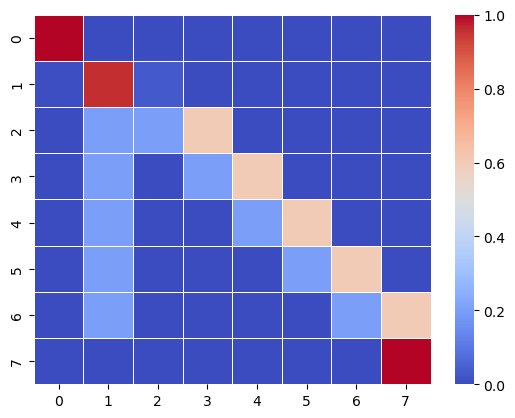

In [35]:
model_demo = BayesianNN(1, 1)
sns.heatmap(model_demo.tmat_demo.detach().to('cpu').numpy(), linewidth=0.5, cmap='coolwarm')

We can perform a simulation of how this hand-crafted transition matrix gets applied in 10 short simulations of a loan where 60 payments of $500 are expected.

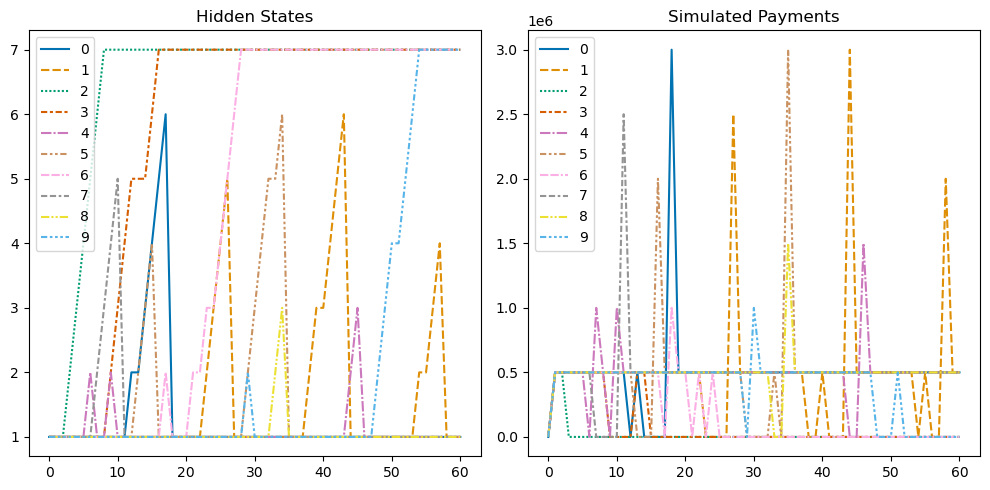

In [37]:
hidden_states, sim_pymnts = model_demo.to(device).forward(
    idx=torch.tensor([0], dtype=torch.int).to(device).repeat(10), 
    installments=torch.ones(60).to(device).repeat(10, 1)*500,
    demo=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(hidden_states.to('cpu').detach().numpy(), ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.to('cpu').detach().numpy()*scaling_factor, ax=ax[1], palette='colorblind')
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

We can now calculate any statistics we might like to calculate on a whole portfolio with respect to just a single loan.

In [51]:
torch.sum(sim_pymnts, dim=0).mean()

tensor(22100., device='cuda:0')

In [54]:
n = 36
print(f'Default rate by month-{n} is: {torch.mean(hidden_states[n-1]==7, dtype=torch.float).item()}')
print(f'Cashflows expected total: {torch.sum(sim_pymnts, dim=0).mean().item()} +/- {torch.sum(sim_pymnts, dim=0).std().item()}')

Default rate by month-36 is: 0.30000001192092896
Cashflows expected total: 22100.0 +/- 11732.6708984375


As this is a Bayesian model we need to define a prior for the state transition matrices.

These probabilities are the model parameters that we wish to infer from the data, so the priors here provide only the min/max values expected based on what's possible in reality (i.e. it's not possible to roll from being up to date to 3 payments late in the space of one month, at least not without refunding the customer for a previous payment, so that prior probability is capped here at a vanishingly small value). The guide here efectively enumerates the full range of allowable state-space transitions.

In [38]:
# Define the guide (variational approximation)
class Guide(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()

        # define the permitted range of transition probabilities
        self.zeros_tmat_prior = torch.tensor([
            [1-1e-4, 0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   0.,    ],
            [0.,     0.,    0.,    0.,    0.,    0.,    0.,   1-1e-4,],]).to(device)
        self.ones_tmat_prior = torch.tensor([
            [1.,    1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  ],
            [1.,    1.,    1.,    1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  ],
            [1.,    1.,    1.,    1.,    1e-4,  1e-4,  1e-4,  1e-4,  ],
            [1.,    1.,    1.,    1.,    1.,    1e-4,  1e-4,  1e-4,  ],
            [1.,    1.,    1.,    1.,    1.,    1.,    1e-4,  1e-4,  ],
            [1.,    1.,    1.,    1.,    1.,    1.,    1.,    1e-4,  ],
            [1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    ],
            [1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  1e-4,  1.,    ],]).to(device)

    def forward(self, idx, installments, pymnts):
        
        # transpose the input tensors to make stacking/indexing slighly easier
        installments = installments.T
        pymnts = pymnts.T
    
        # determine the shape of the inputs
        num_timesteps = installments.shape[0]
        batch_size = installments.shape[1]
    
        with pyro.plate("batch", batch_size, dim=-1):
    
            # Variational parameters for the hidden states
            tmat_prior = pyro.param("tmat_prior", 
                pyro.distributions.Uniform(
                    self.zeros_tmat_prior.unsqueeze(0).repeat(batch_size, 1, 1), 
                    self.ones_tmat_prior.unsqueeze(0).repeat(batch_size, 1, 1)), 
                constraint=dist.constraints.positive)
        
            # Variational posterior for the initial hidden state
            hidden_states = torch.ones(batch_size, dtype=torch.int32).to(device)
        
            for t in range(1, num_timesteps + 1):
                # Variational posterior for each hidden state
                hidden_states = pyro.sample(f"hidden_state_{t}", dist.Categorical(tmat_prior[torch.arange(batch_size), hidden_states]))
                

With the model defined it's time to run the optimisation process, and tune the parameters. The loss here is the difference between the anticipated payment and that that was made, for every account, up to and including each timestep in the sequence.

In [13]:
from tqdm.notebook import tqdm

In [14]:
%%time

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Initialize the model and guide
model = BayesianNN(input_size=dataset.__len__(), embedding_size=16).to(device)
guide = Guide()

# Set up the optimizer and inference algorithm
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(model=model, guide=guide, optim=optimizer, loss=pyro.infer.Trace_ELBO())

# Run inference
batch_size = 384 * 16
num_batches = np.ceil(dataset.__len__() / batch_size)
num_iterations = 5_000
with tqdm(total=num_iterations, desc="Epochs", position=0) as epoch_pbar:
    for step in range(num_iterations):
    #with tqdm(total=num_batches, desc=f"Epoch {step + 1}", position=1, leave=False) as batch_pbar:
        losses = []
        for idx, length, installments, pymnts in DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=collate_fn):
            losses.append(svi.step(idx.to(device), installments.to(device), pymnts.to(device)))
            #batch_pbar.update(1)
        if step % np.ceil(num_iterations/100) == 0:
            print(f"Step {step} : Loss = {np.sum(losses)}")
        epoch_pbar.update(1)


Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0 : Loss = 10207383386547.887
Step 50 : Loss = 10001952062647.668
Step 100 : Loss = 9773262802972.07
Step 150 : Loss = 9527465815531.232
Step 200 : Loss = 9383380904579.19
Step 250 : Loss = 9300503168834.617
Step 300 : Loss = 8914086503785.357
Step 350 : Loss = 9018691830601.477
Step 400 : Loss = 8536398340783.149
Step 450 : Loss = 8324499980908.681
Step 500 : Loss = 7970945344131.553
Step 550 : Loss = 7536625959491.044
Step 600 : Loss = 7210479673935.59
Step 650 : Loss = 7147423097222.121
Step 700 : Loss = 6651128701343.127
Step 750 : Loss = 6357846114583.854
Step 800 : Loss = 6172335005962.9375
Step 850 : Loss = 5854251180307.251
Step 900 : Loss = 5616801513566.468
Step 950 : Loss = 5300811514184.318
Step 1000 : Loss = 5223080902840.756
Step 1050 : Loss = 4916770263129.807
Step 1100 : Loss = 4839099748495.284
Step 1150 : Loss = 4588271566892.588
Step 1200 : Loss = 4370030280622.043
Step 1250 : Loss = 4333416927109.503
Step 1300 : Loss = 4197866692481.658
Step 1350 : Loss = 40370

Above you can see the progress made by the optimiser in reducing the loss. Now we can take a look at some results, and sense-check the outcome. First we'll look at the (average) transition matrix itself seeing this is what lies at the core of the model. Hopefully you can see the similarities between this and the demo I made above.

<Axes: >

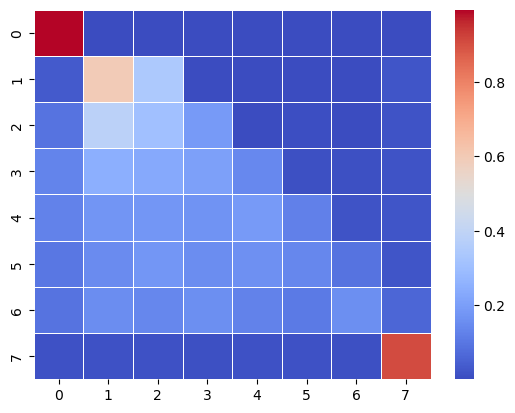

In [39]:
tmat = model.embeddings(torch.arange(dataset.__len__()).to(device))
tmat = model.linear1(tmat)
tmat = model.linear2(F.relu(tmat))
tmat = F.softmax(tmat.reshape(dataset.__len__(), 8, 8), dim=-1)
tmat_mean = torch.mean(tmat, dim=0)
sns.heatmap(tmat_mean.detach().to('cpu').numpy(), linewidth=0.5, cmap='coolwarm')

Next we'll go into a little more detail, looking at a few specific loan examples. The first 5 here represent the accounts with the most variable embedding values, which it may be helpful to think of as a loan performance score. The transition heatmaps are followed by 50 simulations of each of these accounts and their cashflows.

Note: the embeddings have no particular direction in the sense that high 'scores' don't necessarily correspond to good performance as might be expected from a credit risk model, just that accounts with similar score should behave similarly. These 5 heatmaps reflect the variance in the embeddings, i.e. mainly blue with a quite a few red islands indicating high probability of transitioning from a specific y-state to another (often higher) specific x-state.

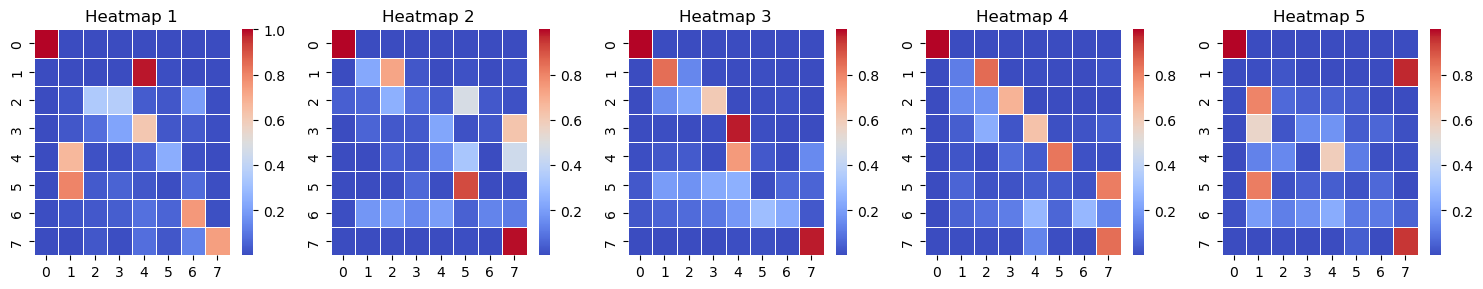

In [17]:
max_embeddings, max_indices = torch.topk(pyro.param('embeddings$$$weight').std(1), 5, largest=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(tmat[max_indices[i]].detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

The hidden state diagrams below tell a sorry story for these accounts categorised by a highly variable loan embedding, with most simulations fairly rapidly transitioning to state 7 (charge-off) from where they no longer yield and payments (simulated payments line converges on 0). Looking at the actual payments we see why this is the case, as many of these accounts are charged off after a relatively short period of time.

tensor(41.3158, device='cuda:0') tensor(44.4154) tensor(44.4787)
tensor(1.2553, device='cuda:0') tensor(1.2184) tensor(2.7690)
tensor(2.9400, device='cuda:0') tensor(2.5288) tensor(5.0328)
tensor(0.4788, device='cuda:0') tensor(0.4268) tensor(0.9550)
tensor(10.3359, device='cuda:0') tensor(9.4186) tensor(24.2564)


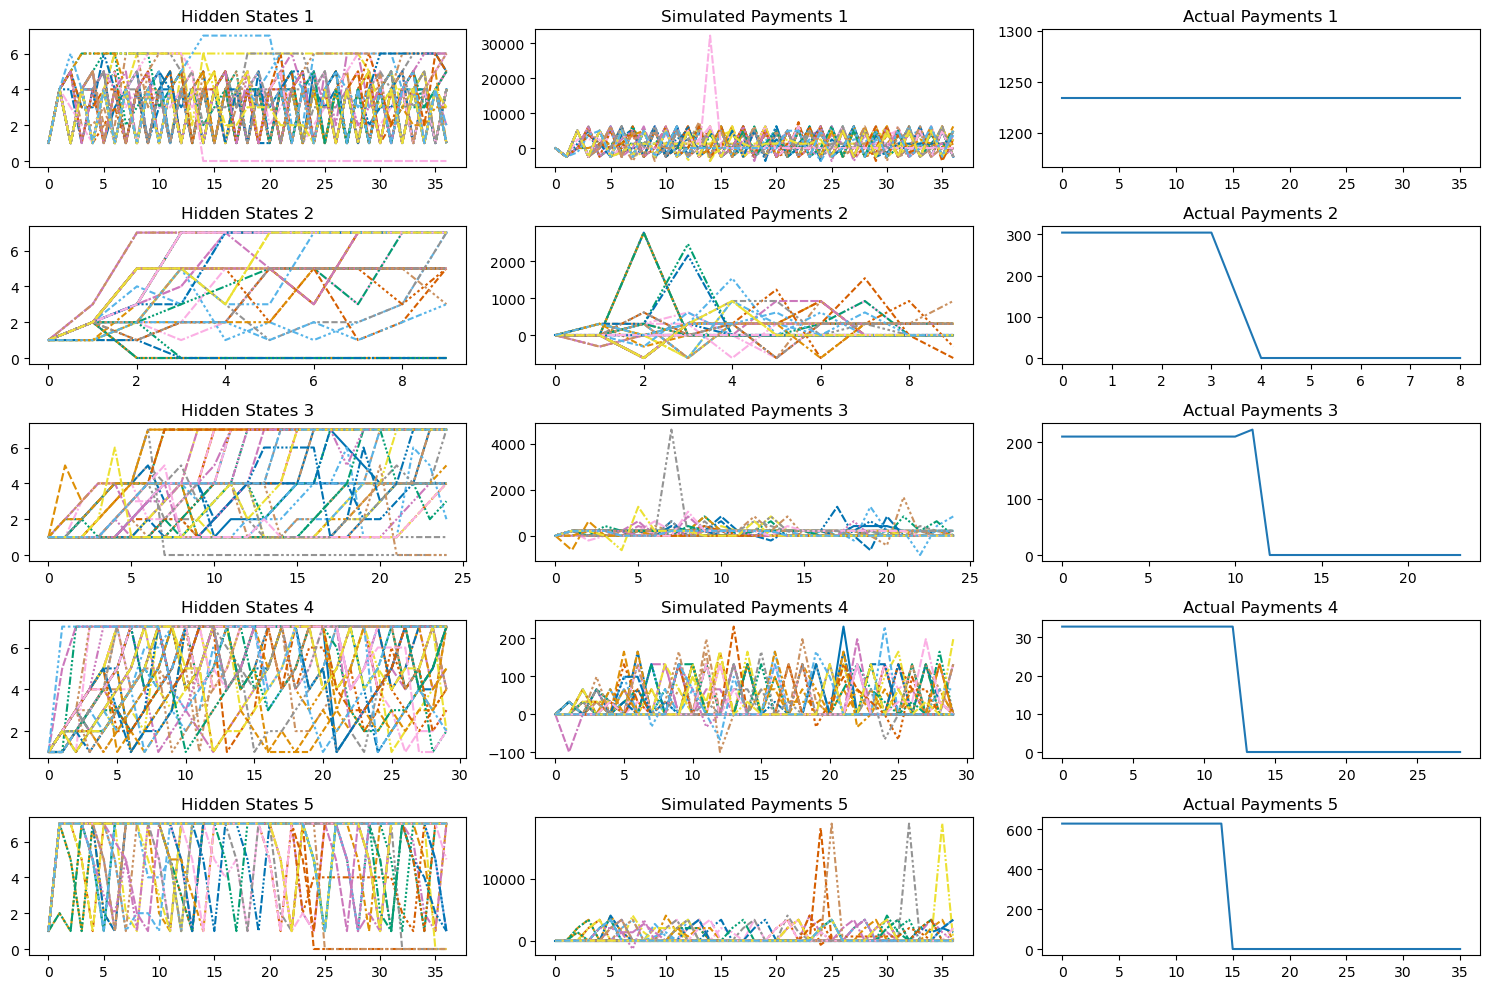

In [18]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    idx = max_indices[i].item()
    idx, length, installments, pymnts = dataset.__getitem__(idx)
    hidden_states, sim_pymnts = model.to(device).forward(torch.tensor([idx], dtype=torch.int).to(device).repeat(50), installments.to(device).repeat(50, 1), pymnts.to(device).repeat(50, 1))
    print(sim_pymnts.sum(0).mean(), pymnts.sum(), installments.sum())
    sns.lineplot(hidden_states.to('cpu').detach().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.to('cpu').detach().numpy()*scaling_factor, ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(pymnts.to('cpu').detach().numpy()*scaling_factor, ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

The same data is then presented for the 5 least variable embedding accounts. These heatmaps are characterised by a mass of mid-blue, indicating much more fluidity.

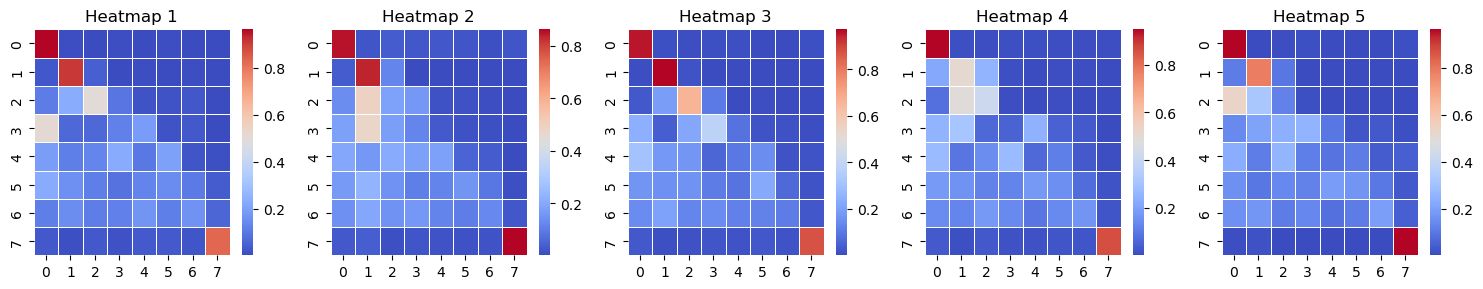

In [19]:
min_embeddings, min_indices = torch.topk(pyro.param('embeddings$$$weight').std(1), 5, largest=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(tmat[min_indices[i]].detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

And, in similar contast to the simulations above, most of these simulations converge on state 0 (fully paid), and the corresponding actual cashflow profiles indicate these loans were indeed paid off early.

tensor(17.3600, device='cuda:0') tensor(25.6064) tensor(16.9446)
tensor(22.0262, device='cuda:0') tensor(28.6888) tensor(19.0879)
tensor(18.9825, device='cuda:0') tensor(26.3480) tensor(18.2312)
tensor(8.2728, device='cuda:0') tensor(23.6807) tensor(8.0961)
tensor(0.9194, device='cuda:0') tensor(0.9350) tensor(0.9511)


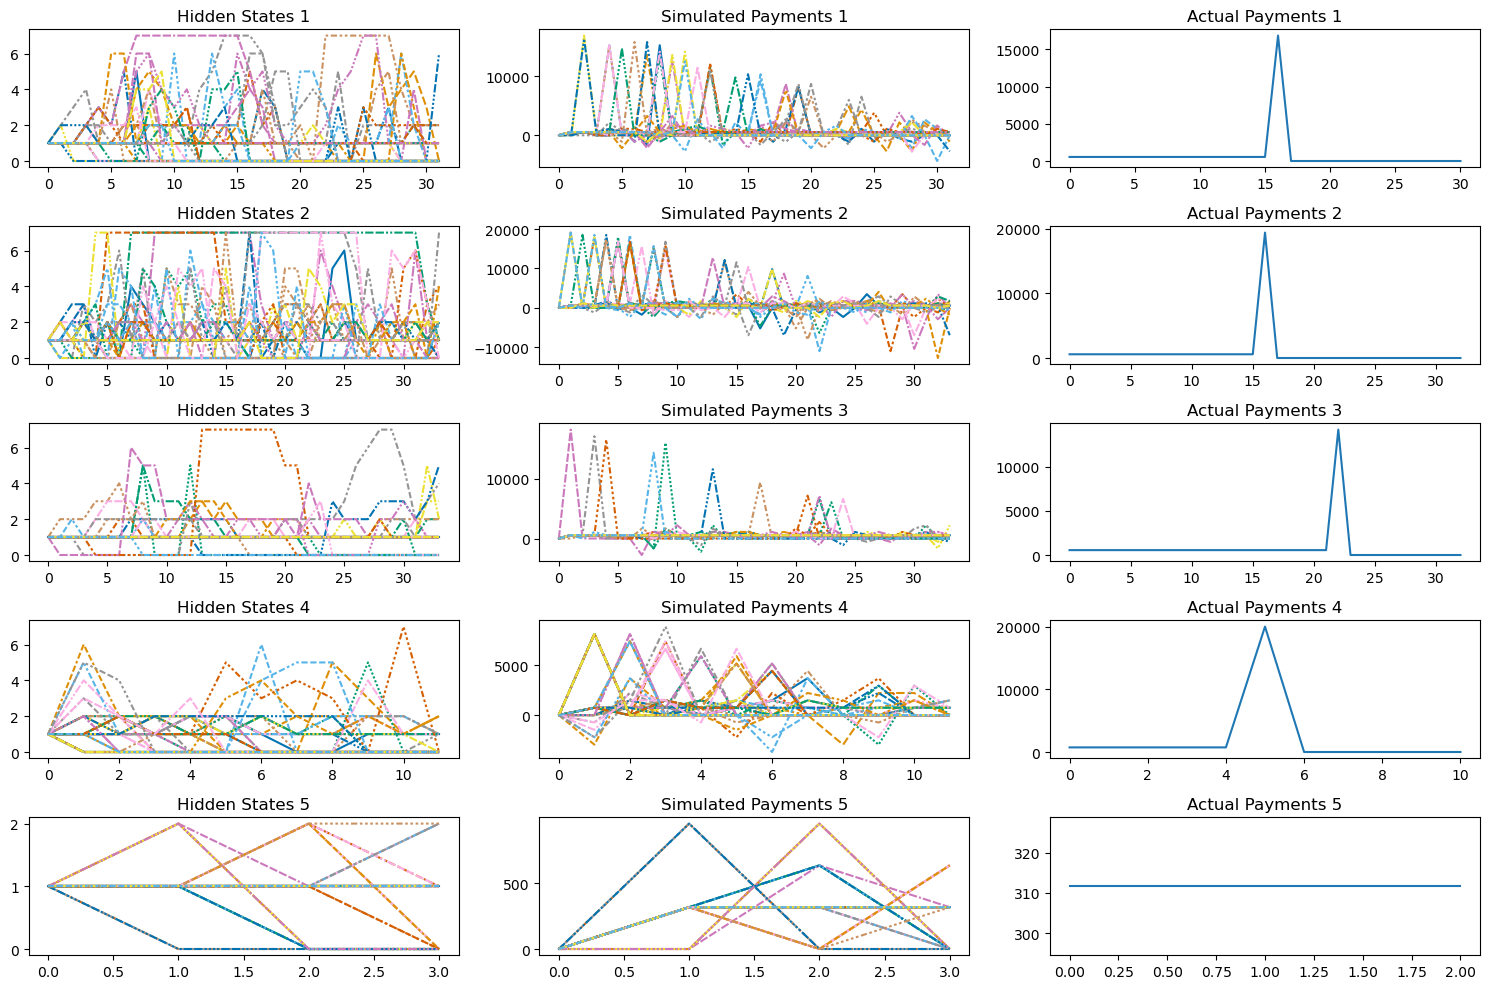

In [20]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    idx = min_indices[i].item()
    idx, length, installments, pymnts = dataset.__getitem__(idx)
    hidden_states, sim_pymnts = model.to(device).forward(torch.tensor([idx], dtype=torch.int).to(device).repeat(50), installments.to(device).repeat(50, 1), pymnts.to(device).repeat(50, 1))
    print(sim_pymnts.sum(0).mean(), pymnts.sum(), installments.sum())
    sns.lineplot(hidden_states.to('cpu').detach().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.to('cpu').detach().numpy()*scaling_factor, ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(pymnts.to('cpu').detach().numpy()*scaling_factor, ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

Finally, the differences between the highest and lowest scoring accounts' heatmaps can finally be seen below. The redness of cell (1,1) indicates the preference for these accounts to remain up to date, and eventually become be paid early as is indicated by the entire first column.

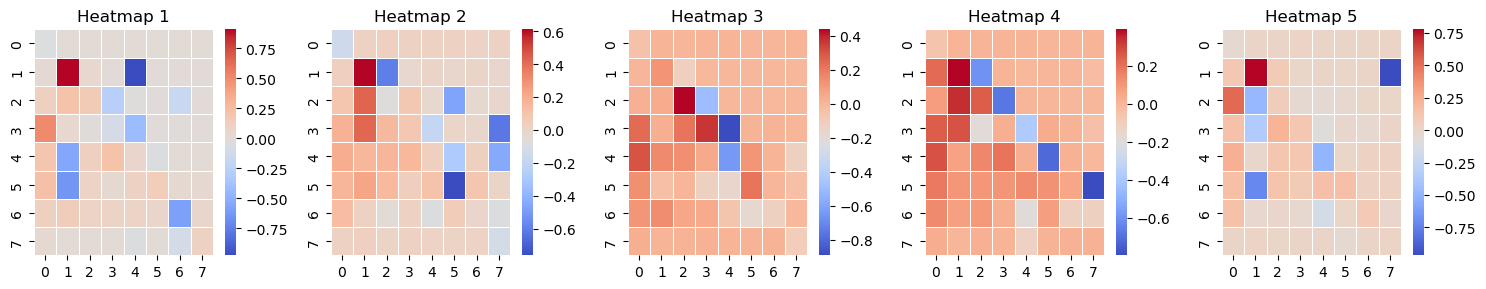

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap((tmat[min_indices[i]]-tmat[max_indices[i]]).detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()